# Практическая работа номер 1: Titanic

Цель работы: построить модель для предсказания процента выживших пассажиров

##Исследование датасета

In [211]:
!pip install phik

In [212]:
!pip install catboost

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import OrdinalEncoder as OE
import phik
from sklearn.preprocessing import StandardScaler as SC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier as cat
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [214]:
gender = pd.read_csv('/content/drive/MyDrive/лабы ML/лаба 1/gender_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/лабы ML/лаба 1/test.csv')
train = pd.read_csv('/content/drive/MyDrive/лабы ML/лаба 1/train.csv')


In [215]:
df = pd.concat([train, test])

In [216]:
df = df.reset_index(drop = True)

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [218]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Заметно, что не все поля датасета заполнены: в полях Age, Cabin и Embarked есть пропуски.

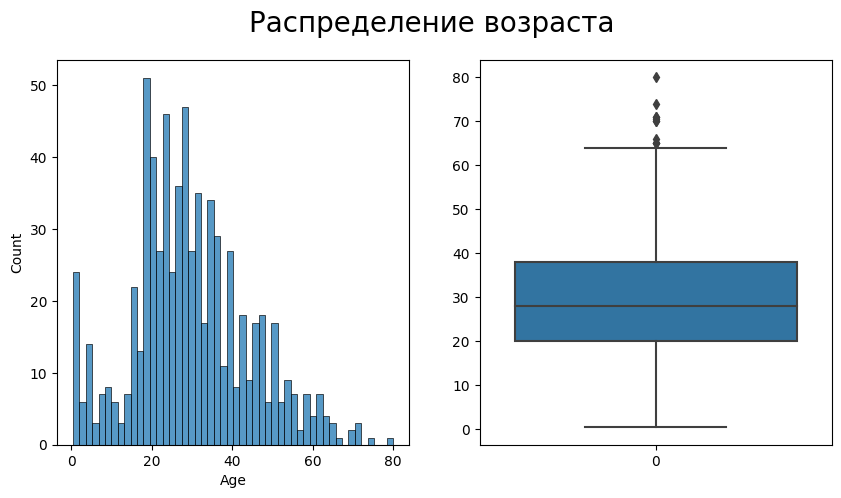

In [219]:
f = plt.figure()
f.set_size_inches(10,5)
f.suptitle('Распределение возраста', fontsize=20)
ax1 = plt.subplot(1, 2, 1)
sns.histplot(train.Age, bins = 50)
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(train.Age)
plt.show()


О возрасте пассажира может говорить приставка в его имени. Для заполнения пропусков в данном столбце сгруппируем пассажиров по приставкам к их именам и заполним пропуски соответствующими медианами

In [220]:
def status_check(x):
    if 'Mrs' in x:
        return 'Mrs'
    elif 'Mr' in x:
        return 'Mr'
    elif 'Miss' in x or 'Mlle' in x:
        return 'Miss'
    elif 'Master' in x:
        return 'Master'
    elif 'Rev' in x:
        return 'Rev'
    elif 'Dr' in x:
        return 'Dr'
    elif 'Major' in x:
        return 'Major'
    elif 'Col' in x:
        return 'Col'
    else:
        return 'NS'

In [221]:
df['status'] = df['Name'].apply(status_check)


In [222]:
medians = pd.pivot_table(df,values = 'Age', index = 'status', aggfunc = 'median')
medians

,Age
status,
Col,54.5
Dr,49.0
Major,48.5
Master,4.0
Miss,22.0
Mr,29.0
Mrs,35.0
NS,38.0
Rev,41.5


In [223]:
medians.loc['Col'][0]

54.5

In [224]:
for i in df['status'].unique():
    df.loc[(df['Age'].isna() == True) & (df['status'] == i) , 'Age'] = medians.loc[i][0]

Разбираемся с пропусками в столбце с номерами кабин

Формат нумерации подразумевает, что первый символ указывает на палубу, которые нумеровались буквами от "A" до "G" сверху вниз, а цифра - на номер комнаты.
 Создадим новые признаки: первый будет содержать информацию о палубе, а второй - о комнате.

Заполним пропуски в данном столбце значением-заглушкой "N000"

In [225]:
df.loc[df['Cabin'].isna() == True, 'Cabin'] = 'N000'


In [226]:
df.loc[df['Cabin'].isna() == True, 'Cabin'].count()

0

In [227]:
df['Deck'] = df['Cabin'].str.slice(0, 1)
df['Room'] = df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False)

In [228]:
df = df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis = 1)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
 8   status    1309 non-null   object 
 9   Deck      1309 non-null   object 
 10  Room      1303 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


Пропуски и нулевые значения в столбце комнат заполним медианами

In [230]:
room_median = df.loc[(df['Room'].isna() == False) & (df['Room'] != '000'), 'Room'].median()

In [231]:
df.loc[(df['Room'].isna() == True) | (df['Room'] == '000'), 'Room'] = room_median

In [232]:
df.Room = df.Room.astype(int)

In [233]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,status,Deck,Room
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,N,43
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,C,85
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,N,43
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,C,123
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,N,43


In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
 8   status    1309 non-null   object 
 9   Deck      1309 non-null   object 
 10  Room      1309 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB


In [235]:
df.loc[df['Fare'].isna() == True, 'Fare'] = df['Fare'].median()

In [236]:
df.loc[df['Embarked'].isna() == True, 'Embarked'] = df['Embarked'].mode()[0]

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   status    1309 non-null   object 
 9   Deck      1309 non-null   object 
 10  Room      1309 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB


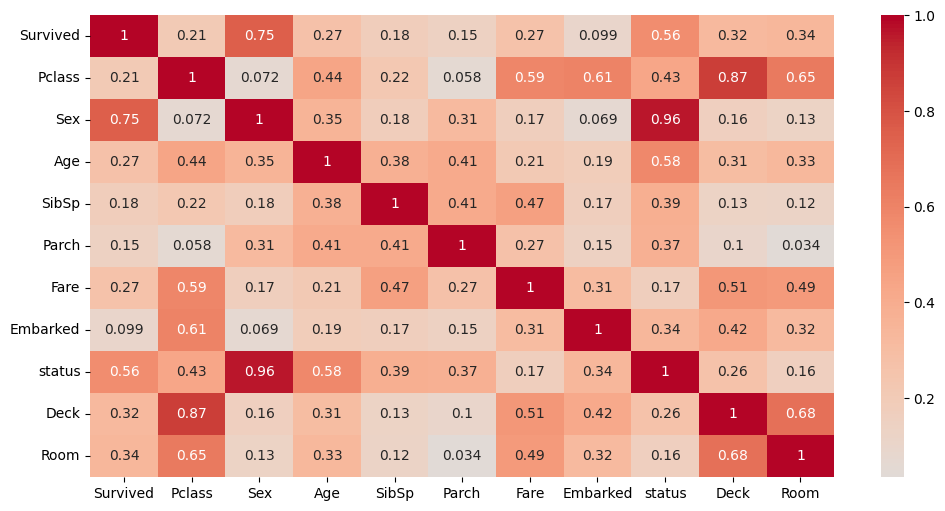

In [238]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.phik_matrix(interval_cols = ['Fare', 'Age', 'Room']), annot = True, cmap = 'coolwarm', center=0)
plt.show()

In [239]:
#df = df.drop('Sex', axis = 1)

In [240]:
#df = df.drop(['Pclass', 'status'], axis = 1)

In [241]:
#ничего хорошего это не дало

In [242]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,status,Deck,Room
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,N,43
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,C,85
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,N,43
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,C,123
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,N,43
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,29.0,0,0,8.0500,S,Mr,N,43
1305,NaN,1,female,39.0,0,0,108.9000,C,NS,C,105
1306,NaN,3,male,38.5,0,0,7.2500,S,Mr,N,43
1307,NaN,3,male,29.0,0,0,8.0500,S,Mr,N,43


### Кодирование

In [243]:
df_train = df[0:891]
df_test = df[891:]

Проверка на дисбаланс классов

In [244]:
df_train.Survived.sum()/df_train.Survived.size

0.3838383838383838

Исправление дисбаланса классов:

In [245]:
#delta = df_train.Survived.size - df_train.Survived.sum() - df_train.Survived.sum()

In [246]:
#balance_data = df_train[df_train['Survived'] == 1].sample(int(delta))

In [247]:
#df_train = pd.concat([df_train, balance_data])

In [248]:
#df_train.Survived.sum()/df_train.Survived.size

In [275]:
#это было плохим решением

In [249]:
train_features = df_train.drop('Survived', axis = 1)
train_target = df_train.Survived

test_features = df_test.drop('Survived', axis = 1)
test_target = df_test.Survived

In [250]:
#test_features.loc[test_features['Fare'].isna() == True] = test_features.Fare.median()#позже пропуск заполнить красиво

In [251]:
obj = df.select_dtypes(include = 'object').columns.to_list()

In [252]:
ohe_encoder = OHE(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ohe_encoder.fit(train_features[obj])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [253]:
train_features_ohe = train_features.copy()
train_features_ohe[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(train_features[obj])
train_features_ohe = train_features_ohe.drop(obj, axis = 1)

In [254]:
train_features_ohe.head()

,Pclass,Age,SibSp,Parch,Fare,Room,Sex_male,Embarked_Q,Embarked_S,status_Dr,...,status_NS,status_Rev,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T
0,3,22.0,1,0,7.2500,43,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,85,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,0,7.9250,43,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,35.0,1,0,53.1000,123,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,35.0,0,0,8.0500,43,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [255]:
test_features_ohe = test_features.copy()
test_features_ohe[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(test_features[obj])
test_features_ohe = test_features_ohe.drop(obj, axis = 1)

In [256]:
test_features_ohe.head()

,Pclass,Age,SibSp,Parch,Fare,Room,Sex_male,Embarked_Q,Embarked_S,status_Dr,...,status_NS,status_Rev,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T
891,3.0,34.5,0.0,0.0,7.8292,43.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
892,3.0,47.0,1.0,0.0,7.0000,43.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
893,2.0,62.0,0.0,0.0,9.6875,43.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
894,3.0,27.0,0.0,0.0,8.6625,43.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
895,3.0,22.0,1.0,1.0,12.2875,43.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [257]:
oe_encoder = OE()
oe_encoder.fit(train_features[obj])

OrdinalEncoder()

In [258]:
train_features_oe = train_features.drop(obj, axis = 1)
train_features_oe[obj] = oe_encoder.transform(train_features[obj])

test_features_oe = test_features.drop(obj, axis = 1)
test_features_oe[obj] = oe_encoder.transform(test_features[obj])

In [259]:
test_features_oe.head()

,Pclass,Age,SibSp,Parch,Fare,Room,Sex,Embarked,status,Deck
891,3.0,34.5,0.0,0.0,7.8292,43.0,1.0,1.0,5.0,7.0
892,3.0,47.0,1.0,0.0,7.0000,43.0,0.0,2.0,6.0,7.0
893,2.0,62.0,0.0,0.0,9.6875,43.0,1.0,1.0,5.0,7.0
894,3.0,27.0,0.0,0.0,8.6625,43.0,1.0,2.0,5.0,7.0
895,3.0,22.0,1.0,1.0,12.2875,43.0,0.0,2.0,6.0,7.0


In [260]:
scaler = SC()
num = ['Age','Fare', 'Room']
train_features_oe[num] = scaler.fit_transform(train_features_oe[num])
train_features_ohe[num] = scaler.fit_transform(train_features_ohe[num])

test_features_oe[num] = scaler.fit_transform(test_features_oe[num])
test_features_ohe[num] = scaler.fit_transform(test_features_ohe[num])

###Обучение моделей:

#### CatBoost

In [261]:
model_1 = cat()

In [262]:
rf_p_dis = {'depth':[1,2,3],
          'iterations':range(10,30,5),
          'learning_rate':np.arange(0.01,0.1,0.01),
          'l2_leaf_reg':[3,5,7,10]}
rdmsearch_1 = RandomizedSearchCV(estimator = model_1, param_distributions = rf_p_dis, n_iter=50, cv=5, scoring = 'roc_auc')
rdmsearch_1.fit(train_features_oe, train_target)
model_1 = rdmsearch_1.best_estimator_

0:	learn: 0.6695100	total: 796us	remaining: 11.1ms
1:	learn: 0.6509958	total: 1.78ms	remaining: 11.6ms
2:	learn: 0.6319639	total: 2.35ms	remaining: 9.39ms
3:	learn: 0.6144194	total: 2.91ms	remaining: 8.01ms
4:	learn: 0.6002601	total: 3.48ms	remaining: 6.96ms
5:	learn: 0.5850834	total: 4.01ms	remaining: 6.02ms
6:	learn: 0.5739975	total: 4.59ms	remaining: 5.24ms
7:	learn: 0.5627103	total: 5.13ms	remaining: 4.49ms
8:	learn: 0.5517038	total: 5.74ms	remaining: 3.83ms
9:	learn: 0.5425307	total: 6.3ms	remaining: 3.15ms
10:	learn: 0.5330701	total: 6.86ms	remaining: 2.49ms
11:	learn: 0.5263856	total: 7.6ms	remaining: 1.9ms
12:	learn: 0.5190051	total: 8.4ms	remaining: 1.29ms
13:	learn: 0.5112155	total: 8.85ms	remaining: 632us
14:	learn: 0.5034430	total: 9.29ms	remaining: 0us
0:	learn: 0.6704391	total: 403us	remaining: 5.65ms
1:	learn: 0.6527375	total: 776us	remaining: 5.05ms
2:	learn: 0.6356179	total: 1.37ms	remaining: 5.46ms
3:	learn: 0.6170298	total: 1.93ms	remaining: 5.31ms
4:	learn: 0.602580

In [263]:
model_1_score = rdmsearch_1.best_score_
print(model_1_score)

0.8593948103954204


####Логистическая регрессия

In [264]:
model_2 = LogisticRegression()

In [265]:
# params = { 'penalty':['l1', 'l2', 'elasticnet', None],
#             'solver':['liblinear', 'newton-cholesky']}
# rsearch = RandomizedSearchCV(estimator = model_2, param_distributions = params, n_iter = 50, cv = 5, scoring = 'roc_auc', verbose = 0)
# rsearch.fit(train_features_ohe, train_target)
# model_2 = rsearch.best_estimator_

In [266]:
params = { 'penalty':['l1', 'l2', 'elasticnet', None],
            'solver':['liblinear', 'newton-cholesky']}
grid = GridSearchCV(model_2, params, scoring = 'roc_auc', verbose = 0)
grid.fit(train_features_ohe, train_target)
model_2 = grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:

In [267]:
model_2_score = grid.best_score_
print(model_2_score)

0.8677252125421369


#### AdaBoost

In [268]:
model_3 = AdaBoostClassifier()
params = {'n_estimators':[10,20,50,70],
        'learning_rate':np.arange(0.1, 1.0, 0.1)}
grid = GridSearchCV(model_3, params, scoring = 'roc_auc', verbose = 0)
grid.fit(train_features_oe, train_target)
model_3 = grid.best_estimator_

In [269]:
model_3_score = grid.best_score_
print(model_3_score)

0.86213203564778


####Случайный лес

In [270]:
model_4 = RandomForestClassifier()
params = {'n_estimators':[50,70, 100, 150],
        'max_depth':np.arange(2,7,1),
          'criterion':['gini', 'entropy', 'log_loss'],
          'min_samples_split':np.arange(2,10,2)}
rdmsearch = RandomizedSearchCV(estimator = model_4, param_distributions = params, n_iter=50, cv=5, scoring = 'roc_auc')
rdmsearch.fit(train_features_oe, train_target)
model_4 = rdmsearch_1.best_estimator_

In [271]:
model_4_score = rdmsearch.best_score_
print(model_4_score)

0.8716491133204922


Лучшая метрика у случайного леса (а accuracy на тесте у AdaBoost)

In [274]:
pred = model_3.predict(test_features_ohe)
pas_ids = list(test['PassengerId'])
df_set = {'PassengerId':pas_ids, 'Survived':pred}
predictions = pd.DataFrame(df_set)
predictions['Survived'] = predictions['Survived'].astype('int')

from google.colab import files
predictions.to_csv('preds.csv', index = False)
files.download('preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>